In [109]:
%%time
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from scipy.stats import norm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None
train = df_train =  pd.read_csv('all/train.csv', nrows = 5_000_00)
test = pd.read_csv('all/test.csv')
#train = train.reindex(np.random.permutation(train.index))
train.head()

Wall time: 5.25 s


In [2]:
df_train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [110]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,500000.000000,500000.000000,500000.000000,499995.000000,499995.000000,500000.000000
mean,11.358361,-72.519958,39.920276,-72.522435,39.916526,1.683428
std,9.916617,11.856831,8.073475,11.797362,7.391002,1.307395
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992047,40.734917,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


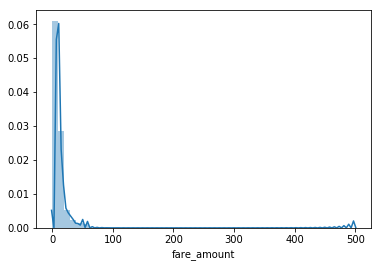

In [144]:
sns.distplot(df_train['fare_amount']);

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


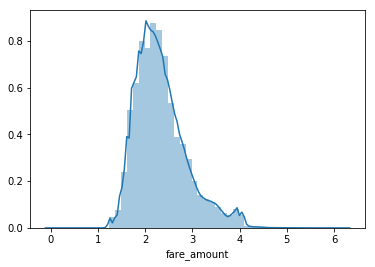

In [143]:
sns.distplot(np.log1p(df_train['fare_amount']));

In [145]:
%%time
#Transforming the Y using log transform (normalization)
df_train['fare_amount'] = np.log1p(df_train['fare_amount']);

Wall time: 458 ms


In [111]:
#Dropping the rows where fare_amount is less than or equal to 0
print('Old size: %d' % len(df_train))
df_train = df_train[df_train.fare_amount>=0]
print('New size: %d' % len(df_train))

Old size: 500000
New size: 499979


In [112]:
print(df_train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
dtype: int64


In [113]:
#Dropping the rows with missing data as the dataset is huge
print('Old size: %d' % len(df_train))
df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))

Old size: 499979
New size: 499974


In [117]:
#Dropping rows where lat long or passenger count is 0
#Latitudes range from -90 to 90.
#Longitudes range from -180 to 180.
#Dropping the outliers
print('Old size: %d' % len(df_train))
df_train.drop(df_train[df_train['pickup_longitude']==0].index,axis=0,inplace=True)
df_train.drop(df_train[df_train['pickup_latitude']==0].index,axis=0,inplace=True)
df_train.drop(((df_train[df_train['pickup_longitude']<-180])|(df_train[df_train['pickup_longitude']>180])).index, axis=0, inplace=True)
df_train.drop(df_train[df_train['dropoff_longitude']==0].index,axis=0,inplace=True)
df_train.drop(df_train[df_train['dropoff_latitude']==0].index,axis=0,inplace=True)
df_train.drop(((df_train[df_train['dropoff_latitude']<-90])|(df_train[df_train['dropoff_latitude']>90])).index, axis=0, inplace=True)
df_train.drop(df_train[df_train['passenger_count']==0].index,axis=0,inplace=True)
print('New size: %d' % len(df_train))

Old size: 490076
New size: 488319


In [118]:
import math
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    Source: http://gis.stackexchange.com/a/56589/15183
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    km = 6367 * c
    return km

In [119]:
def addDistanceFeature(df):
    df['distance (Km)']=df.apply(lambda x: haversine(x['pickup_longitude'],x['pickup_latitude'],x['dropoff_longitude'],x['dropoff_latitude']),axis=1)

In [120]:
%%time
addDistanceFeature(df_train)
addDistanceFeature(test)

Wall time: 2min 5s


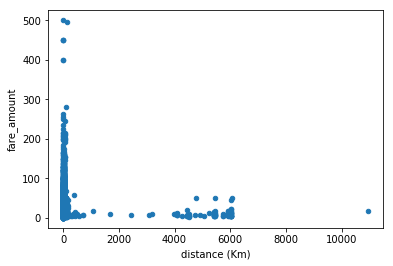

In [121]:
df_train.plot.scatter(x='distance (Km)',y='fare_amount')

In [12]:
df_train['distance (Km)'].head()

0    1.030117
1    8.444828
2    1.388653
3    2.797513
4    1.997902
Name: distance (Km), dtype: float64

In [122]:
print('Old size: %d' % len(df_train))
df_train = df_train[df_train['distance (Km)']<=40]
print('New size: %d' % len(df_train))

Old size: 488319
New size: 488032


In [123]:
df_train['passenger_count'].describe()

count    488032.000000
mean          1.690352
std           1.306445
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: passenger_count, dtype: float64

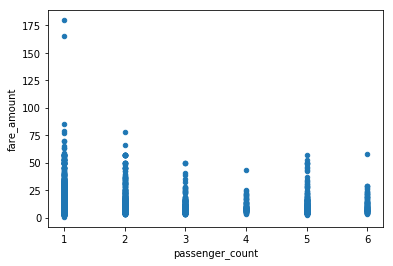

In [19]:
df_train.plot.scatter(x='passenger_count',y='fare_amount')

In [124]:
#Dropping the rows with Passsenger count more than 6
print('Old size: %d' % len(df_train))
df_train = df_train[df_train['passenger_count']<=6]
print('New size: %d' % len(df_train))

Old size: 488032
New size: 488032


In [125]:
def splitPickupDateTime(df):
    df['year']=pd.to_datetime(df['pickup_datetime']).dt.year
    df['month']=pd.to_datetime(df['pickup_datetime']).dt.month
    df['date']=pd.to_datetime(df['pickup_datetime']).dt.day
    df['hour']=pd.to_datetime(df['pickup_datetime']).dt.hour
    df['day_of_week']=pd.to_datetime(df['pickup_datetime']).dt.dayofweek

In [126]:
%%time
splitPickupDateTime(df_train)
splitPickupDateTime(test)

Wall time: 33min 6s


In [55]:
df_train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
distance (Km)        float64
year                   int64
month                  int64
date                   int64
hour                   int64
day_of_week            int64
dtype: object

In [53]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance (Km),year,month,date,hour,day_of_week
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030117,2009,6,15,17,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.444828,2010,1,5,16,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.388653,2011,8,18,0,3
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.797513,2012,4,21,4,5
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.997902,2010,3,9,7,1


In [17]:
df_train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance (Km)', 'year', 'month', 'day', 'time',
       'day_of_week'],
      dtype='object')

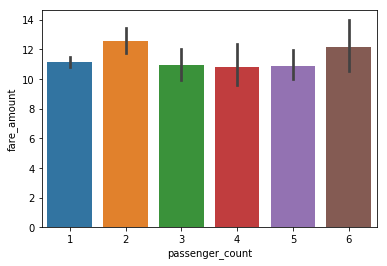

In [56]:
sns.barplot(x='passenger_count',y='fare_amount',data=df_train)

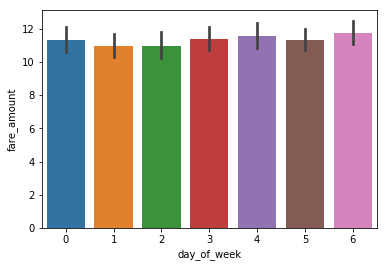

In [57]:
sns.barplot(x='day_of_week',y='fare_amount',data=df_train)

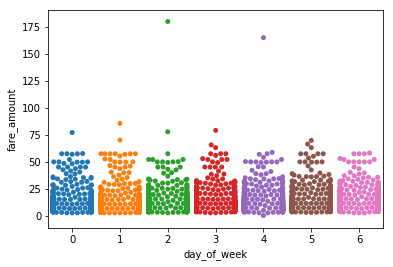

In [58]:
#Very Time Consuming Plot(Don't use every time)
%%time
sns.swarmplot(x="day_of_week", y="fare_amount", data=df_train)

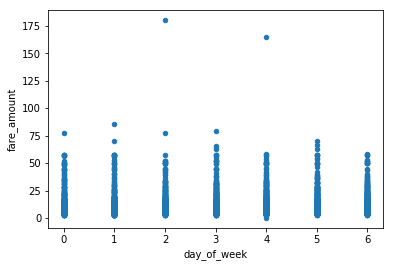

In [59]:
var = 'day_of_week'
data = pd.concat([df_train['fare_amount'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='fare_amount');

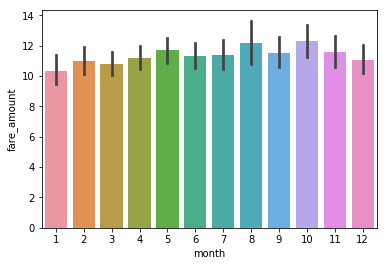

In [60]:
sns.barplot(x='month',y='fare_amount',data=df_train)

In [18]:
# Differentiate numerical features (minus the target) and categorical features

# y = df_train.fare_amount
# categorical_features = df_train.select_dtypes(include = ["object"]).columns
# numerical_features = df_train.select_dtypes(exclude = ["object"]).columns
# numerical_features = numerical_features.drop("fare_amount")
# print("Numerical features : " + str(len(numerical_features)))
# print("Categorical features : " + str(len(categorical_features)))
# train_num = df_train[numerical_features]
# train_cat = df_train[categorical_features]

Numerical features : 9
Categorical features : 4


In [127]:
#Dropping the Categorical Data which has been converted to Numerical individually
df_train.drop(['key','pickup_datetime'], axis = 1,inplace=True)
test.drop(['key','pickup_datetime'], axis = 1,inplace=True)

In [128]:
def dropUnwantedColumns(df):
    df.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1,inplace=True)

In [129]:
dropUnwantedColumns(df_train)
dropUnwantedColumns(test)

In [101]:
df_train.dtypes

fare_amount        float64
passenger_count      int64
distance (Km)      float64
year                 int64
month                int64
date                 int64
hour                 int64
day_of_week          int64
dtype: object

In [146]:
x_train = df_train.iloc[:,df_train.columns!='fare_amount']
y_train = df_train['fare_amount'].values

In [147]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (341622, 7)
X_test : (146410, 7)
y_train : (341622,)
y_test : (146410,)


In [132]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [148]:
%%time
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)


# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())

RMSE on Training set : 0.3027221841385349
RMSE on Test set : 0.3028691484900345
Wall time: 7.37 s


In [151]:
lr_predict = lr.predict(test)
lr_predict = np.expm1(lr_predict)

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


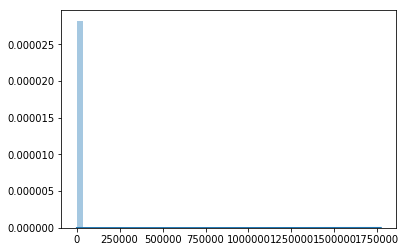

In [152]:
sns.distplot(lr_predict)

In [106]:
%%time
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())

Best alpha : 60.0
Try again for more precision with alphas centered around 60.0
Best alpha : 84.0
Ridge RMSE on Training set : 4.911767352164342
Ridge RMSE on Test set : 5.831005897330594
Wall time: 19.4 s


In [153]:
%%time
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print("Random Forest RMSE on Training set :", rmse_cv_train(rf).mean())
print("Random Forest RMSE on Test set :", rmse_cv_test(rf).mean())
rf_predict = rf.predict(test)

Random Forest RMSE on Training set : 0.2612190899569641
Random Forest RMSE on Test set : 0.26268643720473894
Wall time: 15min 4s


In [154]:
rf_predict = np.expm1(rf_predict)

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


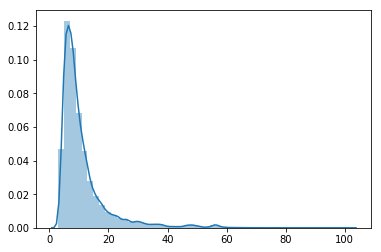

In [155]:
sns.distplot(rf_predict)

In [156]:
submission = pd.read_csv('all/sample_submission.csv')
submission['fare_amount'] = rf_predict
submission.to_csv('submission_1.csv', index=False)
submission.head(20)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.317024
1,2015-01-27 13:08:24.0000003,10.843485
2,2011-10-08 11:53:44.0000002,4.799436
3,2012-12-01 21:12:12.0000002,9.159995
4,2012-12-01 21:12:12.0000003,17.357734
5,2012-12-01 21:12:12.0000005,10.829411
6,2011-10-06 12:10:20.0000001,4.664962
7,2011-10-06 12:10:20.0000003,49.330986
8,2011-10-06 12:10:20.0000002,12.666777
9,2014-02-18 15:22:20.0000002,6.003012


In [ ]:
%%time
import xgboost as xgb
#dtrain = xgb.DMatrix(X_train, label=y_train)
#dtest_cv = xgb.DMatrix(X_test)
params = {'max_depth':3,
          'n_estimators':100,
          'silent':True,
          'learning_rate':0.1
         }
regr = xgb.XGBRegressor(**params)
#evallist = [(dtest_cv, 'eval'), (dtrain, 'train')]
#num_rounds = 50
#early_stopping_rounds=10
xb = regr.fit(X_train, y_train, early_stopping_rounds = 10, eval_set=[(X_test, y_test)])
# calculate the auc score
#preds = xb.predict(dtest_cv)

#print('\nXGBoost Mean Square error" ', mean_squared_error(y_test,preds))

[0]	validation_0-rmse:1.72601
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.55782
[2]	validation_0-rmse:1.40687
[3]	validation_0-rmse:1.27149
[4]	validation_0-rmse:1.15017
[5]	validation_0-rmse:1.04146
[6]	validation_0-rmse:0.944201
[7]	validation_0-rmse:0.857355
[8]	validation_0-rmse:0.77989
[9]	validation_0-rmse:0.71082
[10]	validation_0-rmse:0.649557
[11]	validation_0-rmse:0.59516
[12]	validation_0-rmse:0.547091
[13]	validation_0-rmse:0.504847
[14]	validation_0-rmse:0.467559
[15]	validation_0-rmse:0.435169
[16]	validation_0-rmse:0.406774
[17]	validation_0-rmse:0.382366
[18]	validation_0-rmse:0.361308
[19]	validation_0-rmse:0.343143
[20]	validation_0-rmse:0.32778
[21]	validation_0-rmse:0.314615
[22]	validation_0-rmse:0.303522
[23]	validation_0-rmse:0.294221
[24]	validation_0-rmse:0.286425
[25]	validation_0-rmse:0.279897
[26]	validation_0-rmse:0.274395
[27]	validation_0-rmse:0.269853
[28]	validation_0-rmse:0.266091
[29]	validation_0-rmse:0.26

In [178]:
#dtest = xgb.DMatrix(test)
y_pred_xgb = regr.predict(test)
y_pred_xgb = np.expm1(y_pred_xgb)
submission['fare_amount'] = y_pred_xgb
submission.to_csv('submission_XGB.csv', index=False)
submission.head(20)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.520439
1,2015-01-27 13:08:24.0000003,10.913407
2,2011-10-08 11:53:44.0000002,4.476968
3,2012-12-01 21:12:12.0000002,8.804975
4,2012-12-01 21:12:12.0000003,16.310146
5,2012-12-01 21:12:12.0000005,11.149659
6,2011-10-06 12:10:20.0000001,5.347525
7,2011-10-06 12:10:20.0000003,48.436504
8,2011-10-06 12:10:20.0000002,12.056513
9,2014-02-18 15:22:20.0000002,6.469710


In [73]:
# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

Best alpha : 0.03
Try again for more precision with alphas centered around 0.03
Best alpha : 0.0225
Lasso RMSE on Training set : 5.1085248750001835
Lasso RMSE on Test set : 5.909688029558785


In [74]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

Best l1_ratio : 0.6
Best alpha : 0.03
Try again for more precision with l1_ratio centered around 0.6


C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rohikuma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

KeyboardInterrupt: 